## Perth Basin Case Study using Loop2Flopy


In [ ]:
import numpy as np
import pandas as pd
import numbers
import LoopStructural



### Importing Borehole Data


In [ ]:
bore_info = pd.read_excel(
    "../data/Dwer_data\Formation picks.xls", sheet_name="bore_info"
)

strat_info = pd.read_excel(
    "../data/Dwer_data\Formation picks.xls", sheet_name="strat_info"
)



### Filter data

Crop to desired area and delete columns of less than 2 data points


In [ ]:
df = bore_info.copy()
# x0, x1, y0, y1, z0, z1 = 355000, 402000, 6522000, 6534000, -1200, 200
x0, x1, y0, y1, z0, z1 = 354000, 407000, 6490000, 6545000, -1200, 300
, -1200, 200 # Whole Block
df = df.loc[(df["Northing"] >= y0)]
df = df.loc[(df["Northing"] <= y1)]
# df = df.loc[(df['Easting'] <= x1)]
df = df.drop(["Source"], axis=1)
# df = df.drop(['Tr','Tkm', 'Tk','Tkc','Jc','Kcom','Kps','Kpo','Kpc','Kcoh','Kcp'], axis=1)
# I think we need to keep this general so that we can apply it everywhere...
df = df.reset_index(drop=True)

df

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

print(df.keys)

# Plan of data points
plt.scatter(df.Easting, df.Northing, alpha = 0.1)
plt.xlabel("Easting")
plt.ylabel("Northing")
i = 0
for xi, yi in zip(df.Easting, df.Northing):
    plt.text(xi, yi, df.ID[i], va="bottom", ha="center", fontsize = 6)
    i += 1
fx = [374540,374540,374000,374700,374750,373500,374000,374000]
fy = [6490000,6502303,6515000,6520000,6525000,6530000,6545000,6550000]
plt.plot(fx,fy)
# plt.plot([fx1, fx2], [fy1, fy2])
# plt.plot(fault_center[0], fault_center[1], 'o')
plt.xlim(x0,x1)
plt.ylim(y0,y1)


In [ ]:
lithcodes = list(df.columns.values[3:])  # Make a list of formations
df.Easting = pd.to_numeric(df.Easting)
df.Northing = pd.to_numeric(df.Northing)
df.Ground = pd.to_numeric(df.Ground)
#print(lithcodes)

In [ ]:
strat = []
vdum = [ 38,
        -10,
        -52,
        -124,
        -320,
        -385,
        -435,
        -463,
        -472,
        -494,
        -549,
        -591,
        -657,
        -685,
        -732,
        -888,
        -947,
        -1029,
        -1109,
        -1884,
        -2156,
        -2214,
        -3214,
        -4214
        ]

for i, lith in enumerate(lithcodes):
    index = i
    lithid = i - 1
    val = vdum[i]
    sequence = strat_info.loc[strat_info["unit"] == lith, "sequence"].item()
    R = strat_info.loc[strat_info["unit"] == lith, "R"].item() / 255
    G = strat_info.loc[strat_info["unit"] == lith, "G"].item() / 255
    B = strat_info.loc[strat_info["unit"] == lith, "B"].item() / 255
    strat.append(
        [index, lithid, lith, sequence, val, [round(R, 2), round(G, 2), round(B, 2)]]
    )
strat = pd.DataFrame(strat)
strat.columns = ["index", "lithid", "lithcode", "sequences", "vals", "color"]
strat

In [ ]:

data_list = df.values.tolist()  # Turn data into a list of lists
formatted_data = []
for i in range(len(data_list)):  # iterate for each row
    end = False
    # okay, first we will establish the max value (i.e. the end of the hole)
    stuff = []
    for j in range(3, 26, 1):
        if isinstance(data_list[i][j], numbers.Number) == True:
            stuff.append(data_list[i][j])

    EOH = max(stuff)
    #print(EOH)

    boreid = data_list[i][2]
    easting, northing = data_list[i][0], data_list[i][1]
    groundlevel = data_list[i][3]
    # First channp.nan, np.nan, np.nange - we can get the norms from the geophys data...
    gx, gy, gz = 0.0, 0.0, 1.0  # np.nan, np.nan,np.nan

    # Add data for groundlevel
    val = strat.vals[0]
    formatted_data.append(
        [
            boreid,
            easting,
            northing,
            groundlevel,
            val,
            "Ground",
            "Quaternary",
            gx,
            gy,
            gz,
        ]
    )  # eventually we cn get this from a dem...
    current_bottom = np.copy(groundlevel)

    if isinstance(data_list[i][4], numbers.Number) == True:
        bottom = groundlevel - float(data_list[i][4])  # Ground surface - TQ (mbgl)
        val = strat.vals[1]  # designated isovalue
        lithid = lithcodes[1]  # lithology id
        feat_name = strat.sequences[1]  # sequence name
        formatted_data.append(
            [boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz]
        )
        current_bottom = np.copy(bottom)
    non_conform = [0, #base Quaternary
                   4, #Base Tertiary
                   5, #Base lancelin
                   6, #Base Poison Hill
                   9,#Base Mirrabooka
                   12,#Base Henley
                   15,#Base Mariginiup
                   17,#Base Gage 
                   18,#Base Carnac
                   20,#Base Ottorowirri
                   21,#Base Yarragadee
                   22]
    #This will just tuck the feature up above the unconformity if it is the first in the strat column and absent"
    top_feat = [1,5,6,7,10,13,16,18,19] 
    non_conform_name = ["NC0","NC1","NC2","NC3","NC4","NC5","NC6","NC7","NC8","NC9","NC10","NC11"]
    #gx, gy, gz = np.nan, np.nan,np.nan
    # I know, I know, there isn't any of the tertiary one here, but in being thorough...
    for j in range(5, 26, 1):
        if isinstance(data_list[i][j], numbers.Number) == True:
            if data_list[i][j] < EOH:
                bottom = groundlevel - float(
                    data_list[i][j]
                )  # Ground surface - TQ (mbgl)
                val = strat.vals[j - 3]  # designated isovalue
                end = False
            else:
                bottom = np.copy(current_bottom)  # Ground surface - TQ (mbgl)
                val = strat.vals[j - 4]  # designated isovalue
                end = True
            lithid = lithcodes[j - 3]  # lithology id
            feat_name = strat.sequences[j - 3]  # sequence name
            formatted_data.append(
                [boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz]
            )
            current_bottom = np.copy(bottom)
        #unconfirmities
            if strat.lithid[j - 3] in top_feat and EOH == False:
                val = strat.vals[j - 4]
                bdum = bottom+ 1.
                feat_name = strat.sequences[j - 3]
                lithid = lithcodes[j - 3]
                formatted_data.append(
                    [boreid, easting, northing, bdum, val, lithid, feat_name, gx, gy, gz]
                )         
        """elif end == False:
            if strat.lithid[j - 3] in top_feat:# or strat.lithid[j - 3] in top_feat in non_conform:
                val = strat.vals[j - 3]
                bdum = bottom+ (25.-j) *0.01
                feat_name = strat.sequences[j - 3]
                lithid = lithcodes[j - 3]
                formatted_data.append(
                    [boreid, easting, northing, bdum, val, lithid, feat_name, gx, gy, gz]
                ) """
        if strat.lithid[j - 3] in non_conform:
            if end == False:
                idx = non_conform.index(strat.lithid[j - 3])
                bottom = np.copy(current_bottom)
                val = 0.0
                lithid = non_conform_name[idx]
                feat_name = non_conform_name[idx] + '_FEAT' 
                formatted_data.append(
                    [boreid, easting, northing, bottom, val, lithid, feat_name, 0.0, 0.0, 1.0]
                )           
        





"""#Thomas Break up uncomformity 
X = np.loadtxt('../Geological_data/Geophysical_data/Thomas_transect/BU_thomas.dat')
for i in range(len(X)):
    val = 0.
    lithid = 'Warn_base'
    feat_name = 'WarnUC'
    formatted_data.append(['seis', X[i,0], X[i,1], X[i,2], val, lithid, feat_name, gx, gy, gz]) 

#Thomas Top_SPS
X = np.loadtxt('../Geological_data/Geophysical_data/Thomas_transect/Top_SPS_thomas.dat')
for i in range(len(X)):
    val = vdum[16]
    feat_name = strat.sequences[16] 
    lithid    = lithcodes[16]
    formatted_data.append(['seis', X[i,0], X[i,1], X[i,2], val, lithid, feat_name, gx, gy, gz])"""

data = pd.DataFrame(formatted_data)
data.columns = [
    "ID",
    "X",
    "Y",
    "Z",
    "val",
    "lithcode",
    "feature_name",
    "gx",
    "gy",
    "gz",
]

In [18]:
def get_data(origin,maximum, Lleyland = True, Brett = True):
    bore_info = pd.read_excel(
    "../data/Dwer_data\Formation picks.xls", sheet_name="bore_info"
    )
    
    df = bore_info.copy()
    x0, x1, y0, y1, z0, z1 = origin[0], maximum[0], origin[1], maximum[1], origin[2], maximum[2]
    df = df.loc[(df["Northing"] >= y0)]
    df = df.loc[(df["Northing"] <= y1)]
    df = df.drop(["Source"], axis=1)
    df = df.reset_index(drop=True)

    lithcodes = list(df.columns.values[3:])  # Make a list of formations
    df.Easting = pd.to_numeric(df.Easting)
    df.Northing = pd.to_numeric(df.Northing)
    df.Ground = pd.to_numeric(df.Ground)
    print(lithcodes)
    
    strat_info = pd.read_excel(
    "../data/Dwer_data\Formation picks.xls", sheet_name="strat_info"
    )

    strat = []
    vdum = [ 38,
            -10,
            -52,
            -124,
            -320,
            -385,
            -435,
            -463,
            -472,
            -494,
            -549,
            -591,
            -657,
            -685,
            -732,
            -888,
            -947,
            -1029,
            -1109,
            -1884,
            -2156,
            -2214,
            -3214,
            -4214
            ]

    for i, lith in enumerate(lithcodes):
        index = i
        lithid = i - 1
        val = vdum[i]
        sequence = strat_info.loc[strat_info["unit"] == lith, "sequence"].item()
        R = strat_info.loc[strat_info["unit"] == lith, "R"].item() / 255
        G = strat_info.loc[strat_info["unit"] == lith, "G"].item() / 255
        B = strat_info.loc[strat_info["unit"] == lith, "B"].item() / 255
        strat.append(
            [index, lithid, lith, sequence, val, [round(R, 2), round(G, 2), round(B, 2)]]
        )
    strat = pd.DataFrame(strat)
    strat.columns = ["index", "lithid", "lithcode", "sequences", "vals", "color"]

    data_list = df.values.tolist()  # Turn data into a list of lists
    formatted_data = []
    for i in range(len(data_list)):  # iterate for each row
        end = False
        # okay, first we will establish the max value (i.e. the end of the hole)
        stuff = []
        for j in range(3, 26, 1):
            if isinstance(data_list[i][j], numbers.Number) == True:
                stuff.append(data_list[i][j])

        EOH = max(stuff)
        #print(EOH)

        boreid = data_list[i][2]
        easting, northing = data_list[i][0], data_list[i][1]
        groundlevel = data_list[i][3]
        # First channp.nan, np.nan, np.nange - we can get the norms from the geophys data...
        gx, gy, gz = 0.0, 0.0, 1.0  # np.nan, np.nan,np.nan

        # Add data for groundlevel
        val = strat.vals[0]
        formatted_data.append(
            [
                boreid,
                easting,
                northing,
                groundlevel,
                val,
                "Ground",
                "Quaternary",
                gx,
                gy,
                gz,
            ]
        )  # eventually we cn get this from a dem...
        current_bottom = np.copy(groundlevel)

        if isinstance(data_list[i][4], numbers.Number) == True:
            bottom = groundlevel - float(data_list[i][4])  # Ground surface - TQ (mbgl)
            val = strat.vals[1]  # designated isovalue
            lithid = lithcodes[1]  # lithology id
            feat_name = strat.sequences[1]  # sequence name
            formatted_data.append(
                [boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz]
            )
            current_bottom = np.copy(bottom)
        non_conform = [0, #base Quaternary
                       4, #Base Tertiary
                       5, #Base lancelin
                       6, #Base Poison Hill
                       9,#Base Mirrabooka
                       12,#Base Henley
                       15,#Base Mariginiup
                       17,#Base Gage 
                       18,#Base Carnac
                       20,#Base Ottorowirri
                       21,#Base Yarragadee
                       22]
        #This will just tuck the feature up above the unconformity if it is the first in the strat column and absent"
        top_feat = [1,5,6,7,10,13,16,18,19] 
        non_conform_name = ["NC0","NC1","NC2","NC3","NC4","NC5","NC6","NC7","NC8","NC9","NC10","NC11"]
        #gx, gy, gz = np.nan, np.nan,np.nan
        # I know, I know, there isn't any of the tertiary one here, but in being thorough...
        for j in range(5, 26, 1):
            if isinstance(data_list[i][j], numbers.Number) == True:
                if data_list[i][j] < EOH:
                    bottom = groundlevel - float(
                        data_list[i][j]
                    )  # Ground surface - TQ (mbgl)
                    val = strat.vals[j - 3]  # designated isovalue
                    end = False
                else:
                    bottom = np.copy(current_bottom)  # Ground surface - TQ (mbgl)
                    val = strat.vals[j - 4]  # designated isovalue
                    end = True
                lithid = lithcodes[j - 3]  # lithology id
                feat_name = strat.sequences[j - 3]  # sequence name
                formatted_data.append(
                    [boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz]
                )
                current_bottom = np.copy(bottom)
            #unconfirmities
                if strat.lithid[j - 3] in top_feat and EOH == False:
                    val = strat.vals[j - 4]
                    bdum = bottom+ 1.
                    feat_name = strat.sequences[j - 3]
                    lithid = lithcodes[j - 3]
                    formatted_data.append(
                        [boreid, easting, northing, bdum, val, lithid, feat_name, gx, gy, gz]
                    )         
            """elif end == False:
                if strat.lithid[j - 3] in top_feat:# or strat.lithid[j - 3] in top_feat in non_conform:
                    val = strat.vals[j - 3]
                    bdum = bottom+ (25.-j) *0.01
                    feat_name = strat.sequences[j - 3]
                    lithid = lithcodes[j - 3]
                    formatted_data.append(
                        [boreid, easting, northing, bdum, val, lithid, feat_name, gx, gy, gz]
                    ) """
            if strat.lithid[j - 3] in non_conform:
                if end == False:
                    idx = non_conform.index(strat.lithid[j - 3])
                    bottom = np.copy(current_bottom)
                    val = 0.0
                    lithid = non_conform_name[idx]
                    feat_name = non_conform_name[idx] + '_FEAT' 
                    formatted_data.append(
                        [boreid, easting, northing, bottom, val, lithid, feat_name, 0.0, 0.0, 1.0]
                    )  
    data = pd.DataFrame(formatted_data)
    data.columns = [
        "ID",
        "X",
        "Y",
        "Z",
        "val",
        "lithcode",
        "feature_name",
        "gx",
        "gy",
        "gz",
    ]
    
    if Lleyland:
        valdum = [38.,0.,0.,0.,-732,-888,-947,-1029,0][::-1]
        feature = ['Quaternay','Quaternay','NC1_FEAT','NC5_FEAT',
                   'Leederville','Leederville','Leederville'
                   ,'Warnbro','NC7_FEAT'][::-1]
        
        ddum = []
        Lley = pd.read_excel(
        "../data/Dwer_data\Formation picks.xls", sheet_name="Lleyland"
        )

        for i in range(len(Lley)):
            BoreID = Lley["Name"][i]
            X = Lley["East"][i]
            Y = Lley["North"][i]
            LSE = Lley["Ground"][i]
            ddum.append([BoreID, X, Y, LSE, valdum[-1], 'Lley', feature[-1], 0.0, 0.0, 1.0])
            ddum.append([BoreID, X, Y, LSE-Lley["Break up"][i], valdum[0], 'Lley', feature[0], 0.0, 0.0, 1.0]) 
            if type(Lley["SPS"][i]) == type(1):
                ddum.append([BoreID, X, Y, LSE-Lley["SPS"][i], valdum[1], 'Lley', feature[1], 0.0, 0.0, 1.0])
            if type(Lley["Maringiniup"][i]) == type(1):
                ddum.append([BoreID, X, Y, LSE-Lley["Maringiniup"][i], valdum[2], 'Lley', feature[2], 0.0, 0.0, 1.0])            
            ddum.append([BoreID, X, Y, LSE-Lley["Waneroo"][i], valdum[3], 'Lley', feature[3], 0.0, 0.0, 1.0])
            if type(Lley["Pinjar"][i]) == type(1):
                ddum.append([BoreID, X, Y, LSE-Lley["Pinjar"][i], valdum[4], 'Lley', feature[4], 0.0, 0.0, 1.0])                    
            ddum.append([BoreID, X, Y, LSE-Lley["Aptian"][i], valdum[5], 'Lley', feature[5], 0.0, 0.0, 1.0])   
            if type(Lley["Paleocene"][i]) == type(1):
                ddum.append([BoreID, X, Y, LSE-Lley["Paleocene"][i], valdum[5], 'Lley', feature[5], 0.0, 0.0, 1.0]) 
            ddum.append([BoreID, X, Y, LSE-Lley["TQ"][i], valdum[6], 'Lley', feature[6], 0.0, 0.0, 1.0]) 

        data = pd.concat([data,pd.DataFrame(ddum,columns = data.columns)])
        
    if Brett:
        gphys = pd.read_excel(
        "../data/Dwer_data\Formation picks.xls", sheet_name="Other_constraints")
        ddum = []
        for i in range(len(gphys)):
            ddum.append(['GEO', gphys["Easting"][i], gphys["Northing"][i], gphys["z"][i], gphys["val"][i], 'GEO', gphys["Feature"][i], 0.0, 0.0, 1.0]) 

        data = pd.concat([data,pd.DataFrame(ddum,columns = data.columns)]) 
        
    return(data,lithcodes)
   

    

In [19]:
def make_strat_column(lithcodes):
    strat_info = pd.read_excel(
    "../data/Dwer_data\Formation picks.xls", sheet_name="strat_info"
    )
    
    strat = []
    vdum = [ 38,
            -10,
            -52,
            -124,
            -320,
            -385,
            -435,
            -463,
            -472,
            -494,
            -549,
            -591,
            -657,
            -685,
            -732,
            -888,
            -947,
            -1029,
            -1109,
            -1884,
            -2156,
            -2214,
            -3214,
            -4214
            ]

    for i, lith in enumerate(lithcodes):
        index = i
        lithid = i - 1
        val = vdum[i]
        sequence = strat_info.loc[strat_info["unit"] == lith, "sequence"].item()
        R = strat_info.loc[strat_info["unit"] == lith, "R"].item() / 255
        G = strat_info.loc[strat_info["unit"] == lith, "G"].item() / 255
        B = strat_info.loc[strat_info["unit"] == lith, "B"].item() / 255
        strat.append(
            [index, lithid, lith, sequence, val, [round(R, 2), round(G, 2), round(B, 2)]]
        )
    strat = pd.DataFrame(strat)
    strat.columns = ["index", "lithid", "lithcode", "sequences", "vals", "color"]
    
    stratigraphic_column = {}
    stratigraphic_column["Quaternary"] = {}
    stratigraphic_column["Tertiary"] = {}
    stratigraphic_column["Coolyena_1a"] = {}
    stratigraphic_column["Coolyena_1b"] = {}
    stratigraphic_column["Coolyena_2"] = {}
    stratigraphic_column["Coolyena_3"] = {}
    stratigraphic_column["Leederville"] = {}
    stratigraphic_column["Warnbro"] = {}
    stratigraphic_column["Carnac"] = {}
    stratigraphic_column["Parmelia"] = {}
    stratigraphic_column["Yarragadee"] = {}

    tops = [0,5,6,7,8,11,14,17,19,20,22]
    bots = [5,6,7,10,13,16,18,19,21,22]
    for i in range(0, len(strat) - 1, 1):
        if i in tops:
            maxval = np.inf
        else:
            maxval = strat.vals[i - 1]
        if i in bots:
             minval = -np.inf
        else:
            minval = strat.vals[i]       
        stratigraphic_column[strat.sequences[i]][strat.lithcode[i]] = {
            "min": minval,
            "max": maxval,
            "id": i,
            "color": strat.color[i],
        }
        
    return(stratigraphic_column,strat)


In [20]:


def make_fault_cloud(fx,fy):

    from LoopStructural.utils import strikedip2vector as strike_dip_vector
    x = []
    y = []
    z = []
    nx, ny, nz = [],[],[]
    for ff in range (len(fx) - 1):
        dum_angle = np.rad2deg(np.arctan(np.abs(fy[ff+1] - fy[ff]) / np.abs(fx[ff+1] - fx[ff])))
        if fx[ff+1] > fx[ff]:
            fault_azimuth = 90 - dum_angle
        else:
            fault_azimuth = 90 - dum_angle
        strike, dip = fault_azimuth, 270
        nx1, ny1, nz1 = strike_dip_vector([strike], [dip])[0]
        for i in range (50):
            for k in range(20):
                x.append(fx[ff] + (fx[ff+1]-fx[ff])/49*float(i)-k*25.)
                y.append(fy[ff] + (fy[ff+1]-fy[ff])/49*float(i))
                z.append(-200-1000/19.* float(k) )
                nx.append(nx1)
                ny.append(ny1)
                nz.append(nz1)

    fault_plane_3d = []
    rows = []
    for i in range(len(x)):
        fault_plane_3d.append((x[i], y[i], z[i]))
        df_new_row = pd.DataFrame.from_records(
            {
                "X": [x[i]],
                "Y": [y[i]],
                "Z": [z[i]],
                "val": [0.0],
                "feature_name": ["Fault"],
                "nx": [nx[i]],
                "ny": [ny[i]],
                "nz": [nz[i]],
            }
        )
        rows.append(df_new_row)
    return(rows)

In [27]:
import pandas as pd
import numpy as np
import numbers

class GM:
    
    def __init__(self,origin,maximum):
        self.basedata,lithcodes = get_data(origin,maximum)
        self.origin = origin
        self.maximum = maximum
        self.is_fault = False
        self.is_CP = False
        self.strat_column, self.strat = make_strat_column(lithcodes)
        self.lithcodes = lithcodes
    
    def add_fault(self,faultx,faulty,dmax,cret = True):
        self.is_fault = True
        self.dmax = dmax
        self.cret = cret
        self.fault_rows = make_fault_cloud(faultx,faulty) 
        from LoopStructural.modelling.features.fault._fault_function import (
            CubicFunction,
            FaultDisplacement,
            Composite,
        )
        hw = CubicFunction()
        hw.add_cstr(0, 1)
        hw.add_grad(0, 0)
        hw.add_cstr(1, 0)
        hw.add_grad(1, 0)
        hw.add_max(1)
        fw = CubicFunction()
        fw.add_cstr(0, -1)
        fw.add_grad(0, 0)
        fw.add_cstr(-1, 0)
        fw.add_grad(-1, 0)
        fw.add_min(-1)
        gyf = CubicFunction()
        gyf.add_cstr(-1, 0)
        gyf.add_cstr(1, 0)
        gyf.add_cstr(-0.2, 1)
        gyf.add_cstr(0.2, 1)
        gyf.add_grad(0, 0)
        gyf.add_min(-1)
        gyf.add_max(1)
        gzf = CubicFunction()
        gzf.add_cstr(-1, 0)
        gzf.add_cstr(1, 0)
        gzf.add_cstr(-0.2, 1)
        gzf.add_cstr(0.2, 1)
        gzf.add_grad(0, 0)
        gzf.add_min(-1)
        gzf.add_max(1)
        gxf = Composite(hw, fw)
        fault_displacement = None
        fault_displacement = FaultDisplacement(gx=gxf, gy=gyf, gz=gzf)
        self.faultfunction = fault_displacement
        
        
    def add_control_points(self,x,y,z,val,feat):
        self.is_CP = True
        if type(x) == type(1.) or type(x) == type(1):
            df_new_row = pd.DataFrame.from_records(
                {
                "X": [x],
                "Y": [y],
                "Z": [z],
                "val": [val],
                "feature_name": [feat],
                "nx": [0],
                "ny": [0],
                "nz": [1],
                }
                )
            self.CP_rows = [df_new_row]
        else:
            self.CP_rows = []
            for i in len(x):
                df_new_row = pd.DataFrame.from_records(
                    {
                        "X": [x[i]],
                        "Y": [y[i]],
                        "Z": [z[i]],
                        "val": [val[i]],
                        "feature_name": [feat[i]],
                        "nx": [nx[i]],
                        "ny": [ny[i]],
                        "nz": [nz[i]],
                    }
                )
                self.CP_rows.append(df_new_row)
            
        
    def make_geomodel(self):
        #compile masyter data
        data = self.basedata.copy()
        if self.is_fault:
            for frow in self.fault_rows:
                data = pd.concat([data,frow], ignore_index=True)         
        if self.is_CP:
            for CP in self.CP_rows:
                data = pd.concat([data,CP], ignore_index=True)   
                
        data["Z"] = data["Z"].astype(float)        
        #make loopmodel
        from LoopStructural import GeologicalModel
        self.geomodel = GeologicalModel(
                                        self.origin, 
                                        self.maximum
                                        )  
        #add data
        self.geomodel.data = data
        
        #add foliations
        #First add the quaternary formation
        Quat = self.geomodel.create_and_add_foliation(
            "Quaternary", nelements=2e4, buffer=0.1
        )
        Tert = self.geomodel.create_and_add_foliation(
            "Tertiary", nelements=1e4, buffer=0.1
        )
        TertUC =self.geomodel.create_and_add_foliation(
            "NC1_FEAT", nelements=1e4, buffer=0.1
        )
        UC1 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC1_FEAT"], 0.1
        )
        Cool_1a = self.geomodel.create_and_add_foliation(
            "Coolyena_1a", nelements=1e4, buffer=0.1
        )
        Lancelin_UC = self.geomodel.create_and_add_foliation(
            "NC2_FEAT", nelements=1e4, buffer=0.1
        )
        UC2 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC2_FEAT"], 0
        )
        Cool_1b = self.geomodel.create_and_add_foliation(
            "Coolyena_1b", nelements=1e4, buffer=0.1
        )
        Poison_hill_UC = self.geomodel.create_and_add_foliation(
            "NC3_FEAT", nelements=1e4, buffer=0.1
        )
        UC3 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC3_FEAT"], 0
        )
        Cool_2 = self.geomodel.create_and_add_foliation(
            "Coolyena_2", nelements=1e4, buffer=0.1
        )

        Mirrabooka_UC = self.geomodel.create_and_add_foliation(
            "NC4_FEAT", nelements=1e4, buffer=0.1
        )
        UC4 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC4_FEAT"], 0
        )
        Cool_3 = self.geomodel.create_and_add_foliation(
            "Coolyena_3", nelements=1e4, buffer=0.1
        )
        Henley_UC = self.geomodel.create_and_add_foliation(
            "NC5_FEAT", nelements=1e4, buffer=0.1
        )
        UC5 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC5_FEAT"], 0
        )
        
        if self.cret:
            fault_slip_vector = [0.0, 0, 0.001]
            Fault_1 = self.geomodel.create_and_add_fault(
                "Fault",
                displacement=self.dmax,
                fault_slip_vector=fault_slip_vector,
                minor_axis=10000.,  
                faultfunction = self.faultfunction,
                force_mesh_geometry=True,
                nelements=1e3,
            )
        LEED = self.geomodel.create_and_add_foliation(
            "Leederville", nelements=1e4, buffer=0.1
        )
        LEED_UC = self.geomodel.create_and_add_foliation(
            "NC6_FEAT", nelements=1e4, buffer=0.1
        )
        UC6 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC6_FEAT"], 0
        )
        #SPS and/ or Gage can go missing 
        WARN = self.geomodel.create_and_add_foliation(
            "Warnbro", nelements=1e4, buffer=0.1
        )
        WARN_UC = self.geomodel.create_and_add_foliation(
            "NC7_FEAT", nelements=1e4, buffer=0.1
        )
        UC7 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC7_FEAT"], 0
        )
        '''#Carnac is just unusual, but sometimes it can overly the ottorowirri directly.
        CARN = self.geomodel.create_and_add_foliation(
            "Carnac", nelements=1e4, buffer=0.1
        )
        CARN_UC = self.geomodel.create_and_add_foliation(
            "NC8_FEAT", nelements=1e4, buffer=0.1
        )
        UC8 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC8_FEAT"], 0
        )"""
        """PARM = self.geomodel.create_and_add_foliation(
            "Parmelia", nelements=1e4, buffer=0.1
        )
        PARM_UC = self.geomodel.create_and_add_foliation(
            "NC9_FEAT", nelements=1e4, buffer=0.1
        )
        UC9 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC9_FEAT"], 0
        )
        if not self.cret:
            print("Here")
            fault_slip_vector = [0.0, 0, 0.001]
            Fault_1 = self.geomodel.create_and_add_fault(
                "Fault",
                displacement=self.dmax,
                fault_slip_vector=fault_slip_vector,
                minor_axis=10000.,  
                faultfunction = self.faultfunction,
                force_mesh_geometry=True,
                nelements=1e3,
            )'''
        YARR = self.geomodel.create_and_add_foliation(
            "Yarragadee", nelements=1e4, buffer=0.1
        )
        #add strat_column
        self.geomodel.set_stratigraphic_column(self.strat_column)
        #think about updating modle here...
        self.geomodel.update()
        #makes self.geomodel

[ 3.54e+05  6.49e+06 -1.20e+03] [4.070e+05 6.545e+06 3.000e+02]
['Ground', 'TQ', 'Tr', 'Tkm', 'Tk', 'Tkc', 'Kcl', 'Kcp', 'Kcg', 'Kcm', 'Kcom', 'Kcok', 'Kcomoo', 'Kcoh', 'Kwlp', 'Kwlw', 'Kwlm', 'Kws', 'Kwg', 'Kpc', 'Kps', 'Kpo', 'Jy', 'Jc']


  0%|          | 0/19 [00:00<?, ?it/s]

ERROR: 2024-05-22 16:26:24,088: geological_model.py:1540 -- Model does not contain Parmelia
ERROR: 2024-05-22 16:26:24,088: geological_model.py:1540 -- Model does not contain Carnac


NameError: name 'Ldum' is not defined

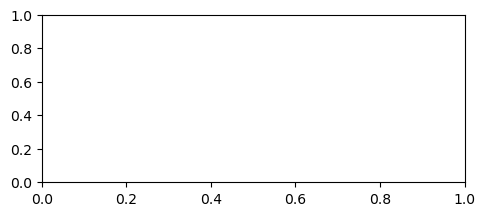

In [30]:
x0, x1, y0, y1, z0, z1 = 354000, 407000, 6490000, 6545000, -1200, 300
origin = np.array([x0, y0, z0]).astype(float)
maximum = np.array([x1, y1, z1]).astype(float)
print(origin,maximum)
Lmod = GM(origin,maximum)
fx = [374540,374541,374000,374700,374750,373500,374000,374001]
fy = [6490000,6502303,6515000,6520000,6525000,6530000,6545000,6550000]
dmax = 175.
Lmod.add_fault(fx,fy,dmax)
Lmod.make_geomodel()
y_transects = [
    6515000,
    6522790,
    6527971,
    6540939,
]

delx, delz = 100, 100

x, z = np.linspace(x0, x1, delx), np.linspace(z0, z1, delz)

xx, zz = np.meshgrid(x, z)

V_strat_column = []

i = 0
import pylab as plt
plt.figure(figsize=(12, 10))

for i in range(4):

    yy = np.zeros_like(xx)

    yy[:] = y_transects[i]

    V_strat_column.append(
        Lmod.geomodel.evaluate_model(
            np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
        ).reshape(np.shape(xx))
    )
    plt.subplot(4, 2, i * 2 + 2)

    plt.contourf(
        xx,zz,V_strat_column[i],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,22],
        colors=Lmod.strat["color"][1:],
    )
    if i == 0:
        plt.plot([368581,368581],[16,16-838])
        plt.plot([371647,371647],[39,39-405])
        plt.plot([374909,374909],[54,54-708])
        plt.plot([386758,386758],[75,75-810])
        plt.plot([400874,400874],[54,54-708])
        plt.plot([373000,372000,371000,370000],[-20,-25,-25,-25],'--')
        plt.plot([373000,372000,371000,370000],[-90,-90,-90,-90],'--')
        plt.plot([373000,372000,371000,370000],[-425,-500,-600,-630],'--')
        plt.plot([372000,371000,370000],[-540,-670,-710],'--')
        plt.plot([373000,372000,371000,370000],[-455,-600,-710,-750],'--')
        """plt.xlim(400000,401000)
        plt.ylim(-1200,80)"""
        
    cbar = plt.colorbar()
    cbar.ax.set_yticklabels(Ldum.lithcodes[1:])

plt.tight_layout()


In [ ]:
Use_Lleyland = True
use_geophys = True
use_CP = True
#Has info on the unconformities and WaRNBRO
valdum = [38.,0.,0.,0.,-732,-888,-947,-1029,0][::-1]
feature = ['Quaternay','Quaternay','NC1_FEAT','NC5_FEAT',
           'Leederville','Leederville','Leederville'
           ,'Warnbro','NC7_FEAT'][::-1]

if Use_Lleyland:
    
    ddum = []
    Lley = pd.read_excel(
    "../data/Dwer_data\Formation picks.xls", sheet_name="Lleyland"
    )

    for i in range(len(Lley)):
        BoreID = Lley["Name"][i]
        X = Lley["East"][i]
        Y = Lley["North"][i]
        LSE = Lley["Ground"][i]
        ddum.append([BoreID, X, Y, LSE, valdum[-1], 'Lley', feature[-1], 0.0, 0.0, 1.0])
        ddum.append([BoreID, X, Y, LSE-Lley["Break up"][i], valdum[0], 'Lley', feature[0], 0.0, 0.0, 1.0]) 
        if type(Lley["SPS"][i]) == type(1):
            ddum.append([BoreID, X, Y, LSE-Lley["SPS"][i], valdum[1], 'Lley', feature[1], 0.0, 0.0, 1.0])
        if type(Lley["Maringiniup"][i]) == type(1):
            ddum.append([BoreID, X, Y, LSE-Lley["Maringiniup"][i], valdum[2], 'Lley', feature[2], 0.0, 0.0, 1.0])            
        ddum.append([BoreID, X, Y, LSE-Lley["Waneroo"][i], valdum[3], 'Lley', feature[3], 0.0, 0.0, 1.0])
        if type(Lley["Pinjar"][i]) == type(1):
            ddum.append([BoreID, X, Y, LSE-Lley["Pinjar"][i], valdum[4], 'Lley', feature[4], 0.0, 0.0, 1.0])                    
        ddum.append([BoreID, X, Y, LSE-Lley["Aptian"][i], valdum[5], 'Lley', feature[5], 0.0, 0.0, 1.0])   
        if type(Lley["Paleocene"][i]) == type(1):
            ddum.append([BoreID, X, Y, LSE-Lley["Paleocene"][i], valdum[5], 'Lley', feature[5], 0.0, 0.0, 1.0]) 
        ddum.append([BoreID, X, Y, LSE-Lley["TQ"][i], valdum[6], 'Lley', feature[6], 0.0, 0.0, 1.0]) 

    data = pd.concat([data,pd.DataFrame(ddum,columns = data.columns)])

if use_geophys:
    gphys = pd.read_excel(
    "../data/Dwer_data\Formation picks.xls", sheet_name="Other_constraints")
    ddum = []
    for i in range(len(gphys)):
        ddum.append(['GEO', gphys["Easting"][i], gphys["Northing"][i], gphys["z"][i], gphys["val"][i], 'GEO', gphys["Feature"][i], 0.0, 0.0, 1.0]) 
        
    data = pd.concat([data,pd.DataFrame(ddum,columns = data.columns)])   
set = 6   
if use_CP:
    CP = pd.read_excel(
    "../data/Dwer_data\Formation picks.xls", sheet_name="CP")
    CP = CP.loc[(CP["set"] == set)]
    CP = CP.reset_index(drop =True)
    ddum = []
    for i in range(len(CP)):
        ddum.append(['CP', CP["X"][i], CP["Y"][i], CP["Z"][i], CP["val"][i], 'CP', CP["Feature"][i], 0.0, 0.0, 1.0]) 
    data = pd.concat([data,pd.DataFrame(ddum,columns = data.columns)])

In [ ]:
pd.DataFrame(ddum,columns = data.columns)


#### Fault stuff


In [ ]:
# The Bado
fx = [374540,374540,374000,374700,374750,373500,374000,374000]
fy = [6490000,6502303,6515000,6520000,6525000,6530000,6545000,6550000]

fx1, fx2 = 373786, 373439
fy1, fy2 = 6528191, 6517059
fz = -800  # [-200,-500]

fault_azimuth = 90 - np.rad2deg(np.arctan(np.abs(fy2 - fy1) / np.abs(fx2 - fx1)))
fault_center = [fx1 + (fx2 - fx1) / 2, fy1 + (fy2 - fy1) / 2, fz]
fault_max_disp = 500.0  # 200?
fault_slip_vector = [0, 0, -1]
major_axis = (
    100000  # np.sqrt((fx2 - fx1)**2 + (fy2 - fy1)**2)/2 # fault_extent - along fault
)
minor_axis = 100000  # Fault_influence - orthogonal to fault
intermediate_axis = 0  # fault_vertical_radius
strike, dip = fault_azimuth, 296

# Make cloud of points along fault plane
'''nh = 50  # points  in x/y plane
x_array, y_array = [], []  # arrays to create points along fault
x_array.append(fx1)
y_array.append(fy1)
for i in range(nh - 2):
    x_array.append(fx1 + (i + 1) * (fx2 - fx1) / (nh - 1))
    y_array.append(fy1 + (i + 1) * (fy2 - fy1) / (nh - 1))
x_array.append(fx2)
y_array.append(fy2)'''



'''z_array = np.arange(-1000, 0, 50)'''

from LoopStructural.utils import strikedip2vector as strike_dip_vector
x = []
y = []
z = []
nx, ny, nz = [],[],[]
for ff in range (len(fx) - 1):
    dum_angle = np.rad2deg(np.arctan(np.abs(fy[ff+1] - fy[ff]) / np.abs(fx[ff+1] - fx[ff])))
    if fx[ff+1] > fx[ff]:
        fault_azimuth = 90 - dum_angle
    else:
        fault_azimuth = 90 - dum_angle
    strike, dip = fault_azimuth, 270
    nx1, ny1, nz1 = strike_dip_vector([strike], [dip])[0]
    for i in range (50):
        for k in range(20):
            x.append(fx[ff] + (fx[ff+1]-fx[ff])/49*float(i)-k*25.)
            y.append(fy[ff] + (fy[ff+1]-fy[ff])/49*float(i))
            z.append(-200-1000/19.* float(k) )
            nx.append(nx1)
            ny.append(ny1)
            nz.append(nz1)

                
                
    

#nv = len(z_array)  # points in z plane



#nx, ny, nz = strike_dip_vector([strike], [dip])[0]
#print(nx, ny, nz)

fault_plane_3d = []
"""for v in range(nv):  # vertical points
    for h in range(nh):  # horizontal points
        x, y, z = x_array[h], y_array[h], z_array[v]
        fault_plane_3d.append((x, y, z))
        df_new_row = pd.DataFrame.from_records(
            {
                "X": [x],
                "Y": [y],
                "Z": [z],
                "val": [0.0],
                "feature_name": ["Fault"],
                "nx": [nx],
                "ny": [ny],
                "nz": [nz],
            }
        )
        data = pd.concat([data, df_new_row], ignore_index=True)"""

for i in range(len(x)):
    fault_plane_3d.append((x[i], y[i], z[i]))
    df_new_row = pd.DataFrame.from_records(
        {
            "X": [x[i]],
            "Y": [y[i]],
            "Z": [z[i]],
            "val": [0.0],
            "feature_name": ["Fault"],
            "nx": [nx[i]],
            "ny": [ny[i]],
            "nz": [nz[i]],
        }
    )
    data = pd.concat([data, df_new_row], ignore_index=True)    

## ADD FAULT (this chunk given to me directly by Lachlan Grose to make an ellipsoid fault)
from LoopStructural.modelling.features.fault._fault_function import (
    CubicFunction,
    FaultDisplacement,
    Composite,
)

hw = CubicFunction()
hw.add_cstr(0, 1)
hw.add_grad(0, 0)
hw.add_cstr(1, 0)
hw.add_grad(1, 0)
hw.add_max(1)
fw = CubicFunction()
fw.add_cstr(0, -1)
fw.add_grad(0, 0)
fw.add_cstr(-1, 0)
fw.add_grad(-1, 0)
fw.add_min(-1)
gyf = CubicFunction()
gyf.add_cstr(-1, 0)
gyf.add_cstr(1, 0)
gyf.add_cstr(-0.2, 1)
gyf.add_cstr(0.2, 1)
gyf.add_grad(0, 0)
gyf.add_min(-1)
gyf.add_max(1)
gzf = CubicFunction()
gzf.add_cstr(-1, 0)
gzf.add_cstr(1, 0)
gzf.add_cstr(-0.2, 1)
gzf.add_cstr(0.2, 1)
gzf.add_grad(0, 0)
gzf.add_min(-1)
gzf.add_max(1)
gxf = Composite(hw, fw)
fault_displacement = None
fault_displacement = FaultDisplacement(gx=gxf, gy=gyf, gz=gzf)
faultfunction = fault_displacement

In [ ]:
data[-10:]

In [ ]:
z

In [ ]:
for lith in lithcodes:
    filtered_df = data[data.lithcode == lith]
    print(
        "\n Lithology = ",
        lith,
        "\n\n",
        filtered_df[
            ["ID", "X", "Y", "Z", "val", "lithcode", "feature_name", "gx", "gy", "gz"]
        ],
    )

filtered_df = data[data.lithcode == "Tert_base"]
print(
    "\n Lithology = ",
    lith,
    "\n\n",
    filtered_df[
        ["ID", "X", "Y", "Z", "val", "lithcode", "feature_name", "gx", "gy", "gz"]
    ],
)
filtered_df = data[data.lithcode == "Cool_base"]
print(
    "\n Lithology = ",
    lith,
    "\n\n",
    filtered_df[
        ["ID", "X", "Y", "Z", "val", "lithcode", "feature_name", "gx", "gy", "gz"]
    ],
)
filtered_df = data[data.lithcode == "Warn_base"]
print(
    "\n Lithology = ",
    lith,
    "\n\n",
    filtered_df[
        ["ID", "X", "Y", "Z", "val", "lithcode", "feature_name", "gx", "gy", "gz"]
    ],
)

### Create Geomodel


In [ ]:
from LoopStructural import GeologicalModel

origin = np.array([x0, y0, z0]).astype(float)
maximum = np.array([x1, y1, z1]).astype(float)

geomodel_strat_column = GeologicalModel(
    origin, maximum
)  # Made using unconformities and a strat column
geomodel_strat_column.data = data

In [ ]:
origin, maximum

In [ ]:
np.isnan(origin)

In [ ]:
data["Z"] = data["Z"].astype(float)

### Add surfaces


In [ ]:
origin = np.array([3.55e05, 6.49e06, -1.20e03])
maximum = np.array([4.02e05, 6.54e06, 2.00e02])
# data = pd.read_csv("ls_data.csv")

geomodel_strat_column = GeologicalModel(
    origin, maximum
)  # Made using unconformities and a strat column
geomodel_strat_column.data = data

#First add the quaternary formations

Quat = geomodel_strat_column.create_and_add_foliation(
    "Quaternary", nelements=2e4, buffer=0.1
)

#This is the unconfrmity at the bas of the model
#UC0 = geomodel_strat_column.add_unconformity(geomodel_strat_column["Quaternary"], -10)
#When all present, the tertiary units appear conformable, so we can have them present


Tert = geomodel_strat_column.create_and_add_foliation(
    "Tertiary", nelements=1e4, buffer=0.1
)

#This is a seperate foliation for the tertiary unconformity
TertUC = geomodel_strat_column.create_and_add_foliation(
    "NC1_FEAT", nelements=1e4, buffer=0.1
)

UC1 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC1_FEAT"], 0.1
)



# The Coolyena is interesting, but the grouping have been made based on if the units appear conformable or not.
#The Lancelin gets it's own
Cool_1a = geomodel_strat_column.create_and_add_foliation(
    "Coolyena_1a", nelements=1e4, buffer=0.1
)

Lancelin_UC = geomodel_strat_column.create_and_add_foliation(
    "NC2_FEAT", nelements=1e4, buffer=0.1
)

UC2 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC2_FEAT"], 0
)



#The Poison Hill gets it's own
Cool_1b = geomodel_strat_column.create_and_add_foliation(
    "Coolyena_1b", nelements=1e4, buffer=0.1
)

Poison_hill_UC = geomodel_strat_column.create_and_add_foliation(
    "NC3_FEAT", nelements=1e4, buffer=0.1
)

UC3 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC3_FEAT"], 0
)


#Then I have grouped the Gingin Chalk. Molecap and... the mirrabooka. Now this is part of the osbourne, 
#but sometimes the Kardinya Shale is absent, so there can be mirabooka over Henley which makes life hard.

Cool_2 = geomodel_strat_column.create_and_add_foliation(
    "Coolyena_2", nelements=1e4, buffer=0.1
)

Mirrabooka_UC = geomodel_strat_column.create_and_add_foliation(
    "NC4_FEAT", nelements=1e4, buffer=0.1
)

UC4 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC4_FEAT"], 0
)



#Then I have the Kardinya and Henley together

Cool_3 = geomodel_strat_column.create_and_add_foliation(
    "Coolyena_3", nelements=1e4, buffer=0.1
)

Henley_UC = geomodel_strat_column.create_and_add_foliation(
    "NC5_FEAT", nelements=1e4, buffer=0.1
)


UC5 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC5_FEAT"], 0
)



#Then we add the Fault.

fault_slip_vector = [0.0, 0, 0.001]
major_axis = (
    100000  # np.sqrt((fx2 - fx1)**2 + (fy2 - fy1)**2)/2 # fault_extent - along fault
)
minor_axis = 100000  #

Fault_1 = geomodel_strat_column.create_and_add_fault(
    "Fault",
    displacement=150.0,
    fault_slip_vector=fault_slip_vector,
    #fault_center = fault_center,
    minor_axis=10000.,  # minor_axis,  # fault_influence
    #major_axis = major_axis, # fault_extent
    #intermediate_axis = 1000., # fault_vertical_radius
    faultfunction = faultfunction, #faultfunction in routines.ipynb
    # nelements=4000, steps=4, interpolatortype="FDI", buffer=0.3, solver='pyamg',
    force_mesh_geometry=True,
    nelements=1e3,
)


#Leederville units seem conformable

LEED = geomodel_strat_column.create_and_add_foliation(
    "Leederville", nelements=1e4, buffer=0.1
)

LEED_UC = geomodel_strat_column.create_and_add_foliation(
    "NC6_FEAT", nelements=1e4, buffer=0.1
)

UC6 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC6_FEAT"], 0
)


#SPS and/ or Gage can go missing 
WARN = geomodel_strat_column.create_and_add_foliation(
    "Warnbro", nelements=1e4, buffer=0.1
)

WARN_UC = geomodel_strat_column.create_and_add_foliation(
    "NC7_FEAT", nelements=1e4, buffer=0.1
)

UC7 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC7_FEAT"], 0
)

#Carnac is just unusual, but sometimes it can overly the ottorowirri directly.
CARN = geomodel_strat_column.create_and_add_foliation(
    "Carnac", nelements=1e4, buffer=0.1
)
"""
#UC8B = geomodel_strat_column.add_unconformity(
#    geomodel_strat_column["Carnac"], -1884)
"""
CARN_UC = geomodel_strat_column.create_and_add_foliation(
    "NC8_FEAT", nelements=1e4, buffer=0.1
)

UC8 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC8_FEAT"], 0
)
"""
#We can assume parmelia and ottorowirri are conformable.
PARM = geomodel_strat_column.create_and_add_foliation(
    "Parmelia", nelements=1e4, buffer=0.1
)

#UC9B = geomodel_strat_column.add_unconformity(
#    geomodel_strat_column["Carnac"], -2214)


PARM_UC = geomodel_strat_column.create_and_add_foliation(
    "NC9_FEAT", nelements=1e4, buffer=0.1
)

UC9 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC9_FEAT"], 0
)

YARR = geomodel_strat_column.create_and_add_foliation(
    "Yarragadee", nelements=1e4, buffer=0.1
)
"""


"""YARR_UC = geomodel_strat_column.create_and_add_foliation(
    "NC10_FEAT", nelements=1e4, buffer=0.1
)

UC10 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC10_FEAT"], 0
)"""



### Add Stratigraphy Column


In [ ]:
stratigraphic_column = {}
stratigraphic_column["Quaternary"] = {}
stratigraphic_column["Tertiary"] = {}
stratigraphic_column["Coolyena_1a"] = {}
stratigraphic_column["Coolyena_1b"] = {}
stratigraphic_column["Coolyena_2"] = {}
stratigraphic_column["Coolyena_3"] = {}
stratigraphic_column["Leederville"] = {}
stratigraphic_column["Warnbro"] = {}
stratigraphic_column["Carnac"] = {}
stratigraphic_column["Parmelia"] = {}
stratigraphic_column["Yarragadee"] = {}

tops = [0,2,6,7,8,11,14,17,19,20,22]
bots = [5,6,7,10,13,16,18,21,22]
for i in range(0, len(strat) - 1, 1):
    if i in tops:
        maxval = np.inf
    else:
        maxval = strat.vals[i - 1]
    if i in bots:
         minval = -np.inf
    else:
        minval = strat.vals[i]       
    stratigraphic_column[strat.sequences[i]][strat.lithcode[i]] = {
        "min": minval,
        "max": maxval,
        "id": i,
        "color": strat.color[i],
    }

geomodel_strat_column.set_stratigraphic_column(stratigraphic_column)
# geomodel_strat_column.update()

# geomodel_scalar_field.update()
stratigraphic_column

### 2D View


In [ ]:
fault_max_disp

In [ ]:
y_transects = [
    6515000,
    6522790,
    6527971,
    6540939,
]

delx, delz = 100, 100

x, z = np.linspace(x0, x1, delx), np.linspace(z0, z1, delz)

xx, zz = np.meshgrid(x, z)

V_strat_column = []

V_scalar_field = []
i = 0

plt.figure(figsize=(12, 10))

for i in range(4):

    yy = np.zeros_like(xx)

    yy[:] = y_transects[i]

    # X_sect = geomodel.evaluate_model(np.array([xx.flatten(),yy.flatten(),zz.flatten()]).T).reshape(np.shape(xx))

    # test = geomodel_strat_column.evaluate_feature_value(
    #     "Tertiary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # # plt.imshow(vals2)

    V_strat_column.append(
        geomodel_strat_column.evaluate_model(
            np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
        ).reshape(np.shape(xx))
    )
    plt.subplot(4, 2, i * 2 + 2)
    # plt.contourf(
    #     geomodel_strat_column.evaluate_feature_value(
    #         "Warnbro", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    #     ).reshape(np.shape(xx)),
    #     10,
    # )
    # plt.contourf(
    #     geomodel_strat_column.evaluate_feature_value(
    #         "Yarragadee", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    #     ).reshape(np.shape(xx)),
    #     10,
    # )
    plt.contourf(
        xx,zz,V_strat_column[i],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,22],
        colors=strat["color"][1:],
    )
    if i == 0:
        plt.plot([368581,368581],[16,16-838])
        plt.plot([371647,371647],[39,39-405])
        plt.plot([374909,374909],[54,54-708])
        plt.plot([386758,386758],[75,75-810])
        plt.plot([400874,400874],[54,54-708])
        plt.plot([373000,372000,371000,370000],[-20,-25,-25,-25],'--')
        plt.plot([373000,372000,371000,370000],[-90,-90,-90,-90],'--')
        plt.plot([373000,372000,371000,370000],[-425,-500,-600,-630],'--')
        plt.plot([372000,371000,370000],[-540,-670,-710],'--')
        plt.plot([373000,372000,371000,370000],[-455,-600,-710,-750],'--')
        """plt.xlim(400000,401000)
        plt.ylim(-1200,80)"""
        
    cbar = plt.colorbar()
    cbar.ax.set_yticklabels(lithcodes[1:])
    # plt.title("Y = " + str(y_transects[i]) + " Strat Column")
    # plt.xticks(
    #     [0, 20, 40, 60, 80, 100],
    #     [x0, x0 + 2000, x0 + 4000, x0 + 6000, x0 + 8000, x0 + 10000],
    # )
    # plt.xlabel("Easting (m)")
    # yticks = []
    # yvals = [-1200, -1000, -800, -600, -400, -200, 0, 200]
    # for ydum in yvals:
    #     n = np.argmin(abs(ydum - z))
    #     yticks.append(n)
    # plt.yticks(yticks, yvals)
    # plt.ylabel("z mAHD)")
    # plt.contour(
    #     geomodel_strat_column.evaluate_feature_value(
    #         "Fault", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    #     ).reshape(np.shape(xx)),
    #     [0],
    # )
    # # plt.contourf(
    # #     geomodel_strat_column.evaluate_feature_value(
    # #         "Yarragadee", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # #     ).reshape(np.shape(xx)),
    # #     10,
    # # )
    # # plt.contourf(
    # #     geomodel_strat_column['Fault'].displacementfeature.evaluate_value(
    # #         geomodel_strat_column.scale(np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T)
    # #     ).reshape(np.shape(xx)),
    # #     10,
    # # )
    # plt.contour(
    #     geomodel_strat_column.evaluate_feature_value(
    #         "CoolUC", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    #     ).reshape(np.shape(xx)),
    #     0,
    # )
    # plt.contour(
    #     geomodel_strat_column.evaluate_feature_value(
    #         "WarnUC", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    #     ).reshape(np.shape(xx)),
    #     0,
    # )
    # # plt.contourf(
    # #     geomodel_strat_column.evaluate_feature_value(
    # #         "Fault", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # #     ).reshape(np.shape(xx)),
    # #     0,
    # )
plt.tight_layout()


In [ ]:
yy[:] = 6540000
test = geomodel_strat_column.evaluate_feature_value(
         "Leederville", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
     ).reshape(np.shape(xx))

plt.imshow(test,origin = 'lower', extent = [x[0],x[-1],z[0],z[-1]], aspect = 20)
plt.colorbar()

In [ ]:
data.loc[(data["ID"] == 'AM14')]

In [ ]:
UC_list = ['NC9_FEAT','NC8_FEAT','NC7_FEAT','NC6_FEAT','NC5_FEAT','NC4_FEAT','NC3_FEAT',
          'NC2_FEAT','NC1_FEAT']
Feat_list = ['Parmelia','Carnac','Warnbro','Leederville','Coolyena_3','Coolyena_2',
             'Coolyena_1b', 'Coolyena_1a','Tertiary','Quaternay']

final = geomodel_strat_column.evaluate_feature_value(
         "Yarragadee", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
     ).reshape(np.shape(xx))
for i in range(len(UC_list)):
    UC = geomodel_strat_column.evaluate_feature_value(
         UC_list[i], np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
     ).reshape(np.shape(xx))
    Feat = geomodel_strat_column.evaluate_feature_value(
         Feat_list[i], np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
     ).reshape(np.shape(xx))
    final[UC>0] = Feat[UC>0]
plt.imshow(final,origin = 'lower')



In [ ]:
test = geomodel_strat_column.evaluate_feature_value(
         "Quaternary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
     ).reshape(np.shape(xx))
plt.imshow(test,origin = 'lower')
#plt.colorbar()

"""test = geomodel_strat_column.evaluate_feature_value(
         "Leederville", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
     ).reshape(np.shape(xx))
plt.imshow(test)
#plt.colorbar()

test = geomodel_strat_column.evaluate_feature_value(
         "Warnbro", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
     ).reshape(np.shape(xx))
plt.imshow(test)
#plt.colorbar()


test = geomodel_strat_column.evaluate_feature_value(
         "Carnac", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
     ).reshape(np.shape(xx))
plt.imshow(test)
#plt.colorbar()"""

test = geomodel_strat_column.evaluate_feature_value(
         "NC5_FEAT", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
     ).reshape(np.shape(xx))
plt.imshow(test,origin = 'lower')
#plt.colorbar()

"""test = geomodel_strat_column.evaluate_feature_value(
         "Yarragadee", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
     ).reshape(np.shape(xx))
plt.imshow(test,origin = 'lower')"""
plt.colorbar()

In [ ]:
vf = geomodel_strat_column["Fault"][1].vector_field()

In [ ]:
ps = geomodel_strat_column.data[["X", "Y", "Z"]].values
vf = geomodel_strat_column["Fault"][1].evaluate_gradient(ps)

In [ ]:
import pyvista as pv

points = pv.PolyData(vf.locations)
points.point_data.set_vectors(vf.vectors, "vectors")
geom = pv.Arrow()

In [ ]:
vectorfield = points.glyph(
    scale="vectors", orient="vectors", geom=geom, tolerance=0.05, factor=100
)

In [ ]:
vectorfield

In [ ]:
stratigraphic_column["Yarragadee"]Z

In [ ]:
import pyvista as pv

p = pv.Plotter(notebook=True)
p.add_mesh(
    geomodel_strat_column["Fault"].displacementfeature.scalar_field(
        geomodel_strat_column.bounding_box
    )
)
# p.add_mesh(geomodel_strat_column["Fault"][0].surfaces(0)[0].vtk)
# for u in stratigraphic_column["Yarragadee"].values():
#     print(u["min"])
#     p.add_mesh(geomodel_strat_column["Yarragadee"].surfaces([u['min']])[0].vtk)
# p.add_mesh(geomodel_strat_column['CoolUC'].surfaces(0)[0].vtk)
p.show()

In [ ]:
geomodel_strat_column["Yarragadee"].faults

In [ ]:
geomodel_strat_column["Yarragadee"].surfaces(
    (
        geomodel_strat_column["Yarragadee"].max()
        - geomodel_strat_column["Yarragadee"].min()
    )
    + geomodel_strat_column["Yarragadee"].min()
)

In [ ]:
geomodel_strat_column["Yarragadee"].faults

In [ ]:
# plt.imshow(Lith,origin = 'lower')
plt.figure(figsize=(12, 10))
for i in range(4):
    # plt.subplot(4, 2, i * 2 + 1)
    # plt.contourf(
    #     V_scalar_field[i],
    #     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
    #     colors=strat["color"][1:],
    # )
    # cbar = plt.colorbar()
    # cbar.ax.set_yticklabels(lithcodes[1:])
    # plt.title("Y = " + str(y_transects[i]) + " Scalar Field")
    # plt.xticks(
    #     [0, 20, 40, 60, 80, 100],
    #     [x0, x0 + 2000, x0 + 4000, x0 + 6000, x0 + 8000, x0 + 10000],
    # )
    # plt.xlabel("Easting (m)")
    # yticks = []
    # yvals = [-1200, -1000, -800, -600, -400, -200, 0, 200]
    # for ydum in yvals:
    #     n = np.argmin(abs(ydum - z))
    #     yticks.append(n)
    # plt.yticks(yticks, yvals)
    # plt.ylabel("z mAHD)")

    plt.subplot(4, 2, i * 2 + 2)

    plt.contourf(
        V_strat_column[i],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        colors=strat["color"][1:],
    )
    cbar = plt.colorbar()
    cbar.ax.set_yticklabels(lithcodes[1:])
    plt.title("Y = " + str(y_transects[i]) + " Strat Column")
    plt.xticks(
        [0, 20, 40, 60, 80, 100],
        [x0, x0 + 2000, x0 + 4000, x0 + 6000, x0 + 8000, x0 + 10000],
    )
    plt.xlabel("Easting (m)")
    yticks = []
    yvals = [-1200, -1000, -800, -600, -400, -200, 0, 200]
    for ydum in yvals:
        n = np.argmin(abs(ydum - z))
        yticks.append(n)
    plt.yticks(yticks, yvals)
    plt.ylabel("z mAHD)")

plt.tight_layout()

In [ ]:
geomodel_strat_column["Yarragadee"].faults[0][0].regions = []
geomodel_strat_column["Yarragadee"].faults[0][1].regions = []
geomodel_strat_column["Yarragadee"].faults[0][2].regions = []

In [ ]:
plt.figure(figsize=(12, 10))
# plt.contourf(
#     V_strat_column[i],
#     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
#     colors=strat["color"][1:],
# )
plt.contour(
    geomodel_strat_column.evaluate_feature_value(
        "Fault", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    ).reshape(np.shape(xx)),
    0,
)

In [ ]:
plt.figure(figsize=(12, 10))
# plt.contourf(
#     V_strat_column[i],
#     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
#     colors=strat["color"][1:],
# )
plt.contourf(
    geomodel_strat_column.evaluate_feature_value(
        "Quaternary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    ).reshape(np.shape(xx)),
    10,
)
# # plt.contour(
# #     geomodel_strat_column.evaluate_feature_value(
# #         "Quaternary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
# #     ).reshape(np.shape(xx)),
# #     [-10.],
# # )
# plt.contourf(
#     geomodel_strat_column.evaluate_feature_value(
#         "Tertiary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
#     ).reshape(np.shape(xx)),
#     10,
# )
# plt.contour(
#     geomodel_strat_column.evaluate_feature_value(
#         "Tertiary_unconformity", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
#     ).reshape(np.shape(xx)),
#     5,
# )
# plt.contourf(
#     geomodel_strat_column.evaluate_feature_value(
#         "Coolyena", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
#     ).reshape(np.shape(xx)),
#     10,
# )
# # plt.contour(
# #     geomodel_strat_column.evaluate_feature_value(
# #         "CoolUC_unconformity", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
# #     ).reshape(np.shape(xx)),

# # )
# # plt.contour(
# #     geomodel_strat_column.evaluate_feature_value(
# #         "Tertiary_unconformity", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
# #     ).reshape(np.shape(xx)),
# #     0,
# # )
# # plt.contourf(
# #     geomodel_strat_column.evaluate_feature_value(
# #         "Quaternary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
# #     ).reshape(np.shape(xx)),
# #     0,
# # )
# plt.contourf(
#     geomodel_strat_column.evaluate_feature_value(
#         "Warnbro", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
#     ).reshape(np.shape(xx)),
#     10,
# )
# plt.contourf(
#     geomodel_strat_column.evaluate_feature_value(
#         "Yarragadee", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
#     ).reshape(np.shape(xx)),
#     10,
# )
# tmp = np.copy(valsa)
# tmp[valsb > 0] = np.nan
# plt.contour(valsb, 0,color='black')
# plt.contour(vals3, 0, color="black")
# plt.contour(vals5, 0, color="black")
# # plt.contourf(dum,5)

In [ ]:
raise Exception

In [ ]:
plt.contour(valsb, 0)
plt.contour(vals3, 0)
plt.contour(vals5, 0)

In [ ]:
geomodel_strat_column["Tertiary"].regions

In [ ]:
y_transects = [
    6505000,
    6515000,
    6525000,
    6532000,
]

delx, delz = 100, 100

x, z = np.linspace(x0, x1, delx), np.linspace(z0, z1, delz)

xx, zz = np.meshgrid(x, z)

V_strat_column = []

V_scalar_field = []

test_val = []
for i in range(4):
    yy = np.zeros_like(xx)

    yy[:] = y_transects[i]
    pts = np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    pts = geomodel_strat_column.rescale(pts)

    tertiary_unconformity = (
        geomodel_strat_column["Tertiary_unconformity"]
        .evaluate_value(pts)
        .reshape(np.shape(xx))
    )

    test_val.append(tertiary_unconformity)

    # # X_sect = geomodel.evaluate_model(np.array([xx.flatten(),yy.flatten(),zz.flatten()]).T).reshape(np.shape(xx))

    # vals1 = geomodel_scalar_field.evaluate_feature_value(
    #     "Quaternary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # valsa = geomodel_scalar_field.evaluate_feature_value(
    #     "Tertiary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # valsb = geomodel_scalar_field.evaluate_feature_value(
    #     "Tertiary_unconformity", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # vals2 = geomodel_scalar_field.evaluate_feature_value(
    #     "Coolyena", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # vals3 = geomodel_scalar_field.evaluate_feature_value(
    #     "CoolUC", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # vals4 = geomodel_scalar_field.evaluate_feature_value(
    #     "Warnbro", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # vals5 = geomodel_scalar_field.evaluate_feature_value(
    #     "WarnUC", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # vals6 = geomodel_scalar_field.evaluate_feature_value(
    #     "Yarragadee", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # # plt.imshow(vals2)

    # valsa[valsa > -10] = -10

    # valsa[valsa < -385] = -385

    # vals2[vals2 > -385] = -385

    # vals2[vals2 < -619] = -619

    # vals4[vals4 > -619] = -619

    # vals4[vals4 < -1043] = -1043

    # vals6[vals6 > -1043] = -1043

    # dum = np.ones_like(vals4) * -10000

    # dum[vals5 < 0] = vals6[vals5 < 0]

    # dum[vals5 > 0] = vals4[vals5 > 0]

    # dum[vals3 > 0] = vals2[vals3 > 0]

    # dum[valsb > 0] = valsa[valsb > 0]

    # dum[vals1 > -10] = vals1[vals1 > -10]

    # Lith = np.ones_like(dum) * -1

    # for i in range(len(vdum) - 2, -1, -1):

    #     Lith[dum > vdum[i]] = i

    # Lith[dum > 30.0] = 0

    V_scalar_field.append(Lith)

    V_strat_column.append(
        geomodel_strat_column.evaluate_model(
            np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
        ).reshape(np.shape(xx))
    )

In [ ]:
stratigraphic_column["Tertiary"]

In [ ]:
p = pv.Plotter()
p.add_mesh(model["Tertiary_unconformity"].surfaces(0)[0])
for unit in stratigraphic_column["Tertiary"].values():
    p.add_mesh(model[unit["feature"]].surfaces(0)[0])
p.set_scale(zscale=5)
p.show()

In [ ]:
test_val

In [ ]:
# plt.imshow(Lith,origin = 'lower')
plt.figure(figsize=(12, 10))
for i in range(4):
    # plt.subplot(4, 2, i * 2 + 1)
    # plt.contourf(
    #     V_scalar_field[i],
    #     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
    #     colors=strat["color"][1:],
    # )
    # cbar = plt.colorbar()
    # cbar.ax.set_yticklabels(lithcodes[1:])
    # plt.title("Y = " + str(y_transects[i]) + " Scalar Field")
    # plt.xticks(
    #     [0, 20, 40, 60, 80, 100],
    #     [x0, x0 + 2000, x0 + 4000, x0 + 6000, x0 + 8000, x0 + 10000],
    # )
    # plt.xlabel("Easting (m)")
    # yticks = []
    # yvals = [-1200, -1000, -800, -600, -400, -200, 0, 200]
    # for ydum in yvals:
    #     n = np.argmin(abs(ydum - z))
    #     yticks.append(n)
    # plt.yticks(yticks, yvals)
    # plt.ylabel("z mAHD)")

    plt.subplot(4, 2, i * 2 + 2)
    plt.contour(test_val[i], levels=[0], colors="black")
    plt.contourf(
        V_strat_column[i],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        colors=strat["color"][1:],
    )
    cbar = plt.colorbar()
    cbar.ax.set_yticklabels(lithcodes[1:])
    plt.title("Y = " + str(y_transects[i]) + " Strat Column")
    plt.xticks(
        [0, 20, 40, 60, 80, 100],
        [x0, x0 + 2000, x0 + 4000, x0 + 6000, x0 + 8000, x0 + 10000],
    )
    plt.xlabel("Easting (m)")
    yticks = []
    yvals = [-1200, -1000, -800, -600, -400, -200, 0, 200]
    for ydum in yvals:
        n = np.argmin(abs(ydum - z))
        yticks.append(n)
    plt.yticks(yticks, yvals)
    plt.ylabel("z mAHD)")

plt.tight_layout()